# Deep Belief Networks on EMNIST dataset



*   NAME: SKURATIVSKA KATERYNA
*   STUDENT ID: 2081787
*   DATE: 29/06/2023



# UPLOADING LIBRARIES

First thing to do is upload libraries used for DBN and RBM implementation used in laboratories during the course.

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
!pip install emnist

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import tensorflow as tf
from tqdm.notebook import tqdm
import torch.nn.functional as functional

from emnist import list_datasets

from DBN import DBN

Choose dynamically the kind of device used for computations (CPU or GPU).

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


# DATA UPLOADING

Uploading EMNIST dataset with a split `'letters'`, converting to a tensor and saving in a train and test sets. Train and test datasets contain respectively  124800 and 20800 images, each images is `28x28` pixel size. EMNIST dataset contains 27 labels.

In [ ]:
transform = tv.transforms.Compose( [tv.transforms.ToTensor()] )

emnist_train = tv.datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
emnist_test = tv.datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)


In [ ]:
print(emnist_train)
print(emnist_test)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset EMNIST
    Number of datapoints: 20800
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


On this step we normalize the dataset and rotate the images array.

In [ ]:
emnist_train.data = emnist_train.data.type(torch.FloatTensor)/255
emnist_train.data = torch.transpose(emnist_train.data, 1, 2).contiguous()
emnist_train.data = torch.flip(emnist_train.data, dims=[1])

emnist_test.data = emnist_test.data.type(torch.FloatTensor)/255
emnist_test.data = torch.transpose(emnist_test.data, 1, 2).contiguous()
emnist_test.data = torch.flip(emnist_test.data, dims=[1])

Let's plot some example from train dataset

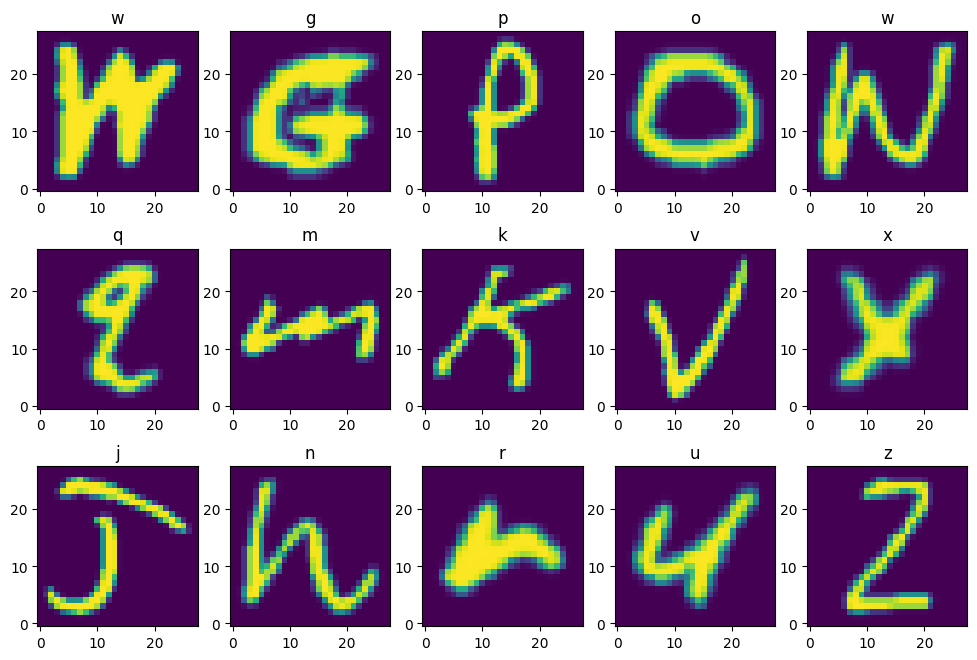

In [ ]:
fig,axes = plt.subplots(3,5,figsize=(12,8))
for idx,ax in enumerate(axes.flat):
    img = emnist_train.data[idx]
    label = emnist_train.targets[idx]
    symbol = emnist_train.classes[label]
    ax.imshow(img , cmap = 'viridis', origin='lower')
    ax.text(0.5, 1.05, symbol, transform=ax.transAxes, fontsize=12, ha='center')

In [ ]:
number_of_classes = len(emnist_train.classes)
print("Total number of classe: ", number_of_classes)

Total number of classe:  27


In [ ]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)

emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

# TRAINING DBN



For classificatio EMNIST dataset I increased the number of hidden layers, so pur model can learn more differences between different labels. Compared to MNIST dataset with 10 labels in EMNIST dataset has 27 labels. So therefore it needs more complex structure and more time for learning. Therefore I also incresed number of epochs.

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500, 600, 700, 800],
                k=1,
                learning_rate=0.01,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [ ]:
num_epochs = 100
batch_size = 125

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1624     |0.0349       |48.7832   |1.3044     |
|20    |1.1434     |0.0348       |48.0628   |1.1481     |
|30    |1.1282     |0.0335       |47.3831   |1.1320     |
|40    |1.1198     |0.0333       |47.1174   |1.0334     |
|50    |1.1128     |0.0338       |46.9430   |1.0226     |
|60    |1.1081     |0.0322       |46.5167   |1.0121     |
|70    |1.1046     |0.0326       |46.5498   |1.1000     |
|80    |1.1012     |0.0328       |46.4059   |1.0115     |
|90    |1.0988     |0.0325       |46.2122   |0.9829     |
|100    |1.0973     |0.0328       |46.1404   |1.0136     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7212     |0.0483       |51.1536   |1.1824     |
|20    |1.4399     |0.0336       |45.0538   |0.9226     |
|30    |1.4018     |0.0338       |43.8901   |0.8751     |
|40    |1.3884     |0.0319       |43.6200   |

## Visualizing receptive fields

We trained the network, and now we are going to visualize the learned weights. In order to do so, we will plot some of the weights in a picture of the same size of the EMNIST images we used for training. In this way, we will see which parts of an image trigger the unit associated with a specific weight vector.

We will also apply a threshold on the learned weights, in order to make the plots less noisy. The values in different weigths could have different ranges, so we will use a `MinMaxScaler` from Scikit-Learn to make a meaningful comparison among the visualizations of different receptive fields.

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

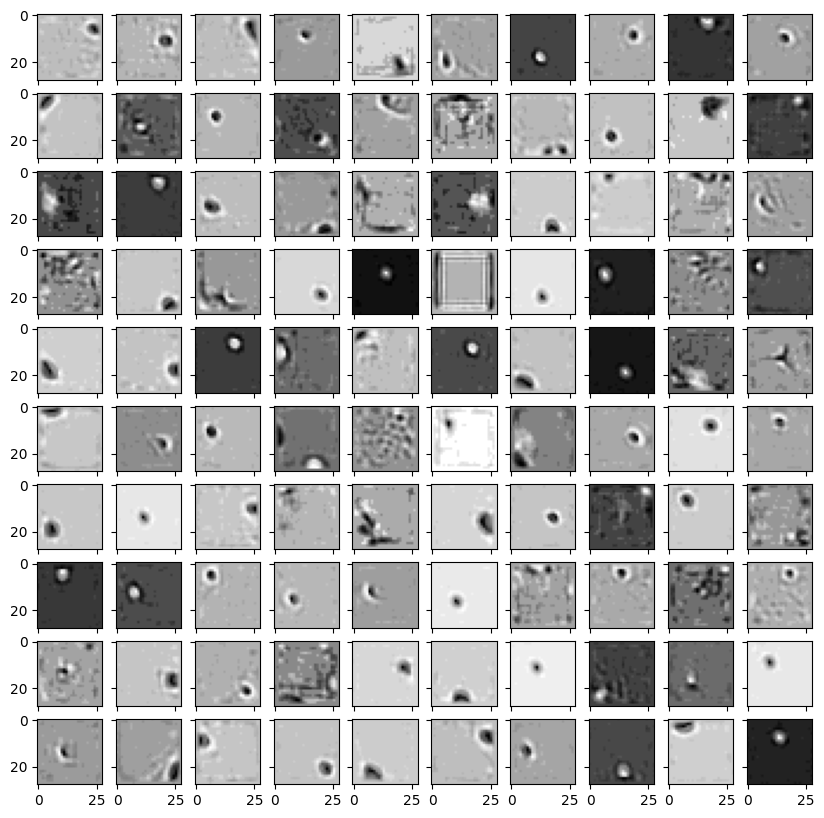

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

The weights in the second and third hidden layers have don't have the same dimensionality as MNIST digits, therefore, we will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images.

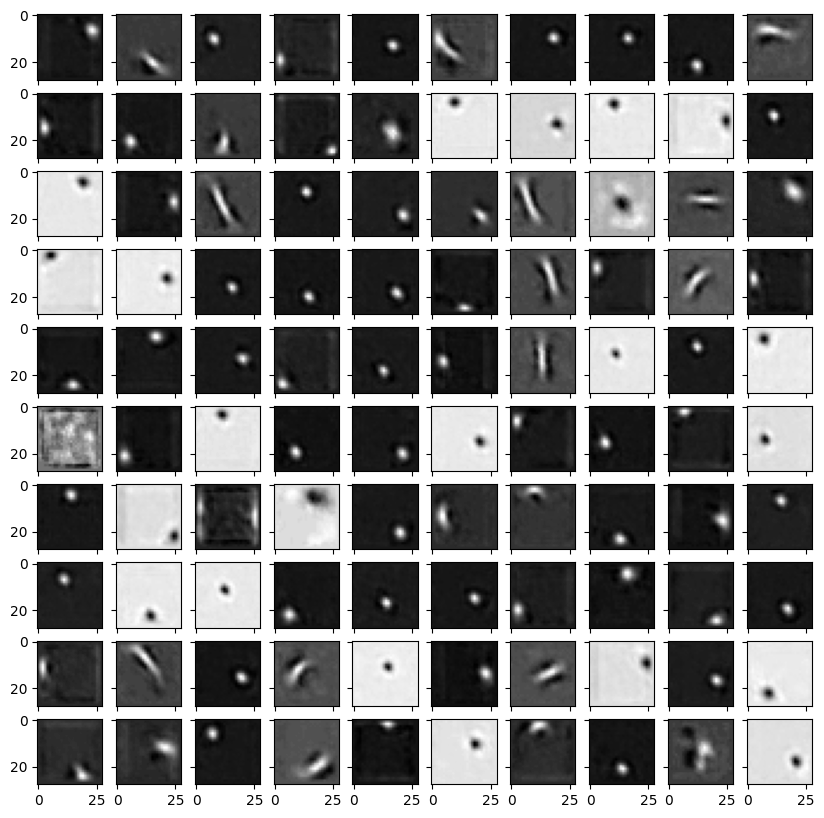

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

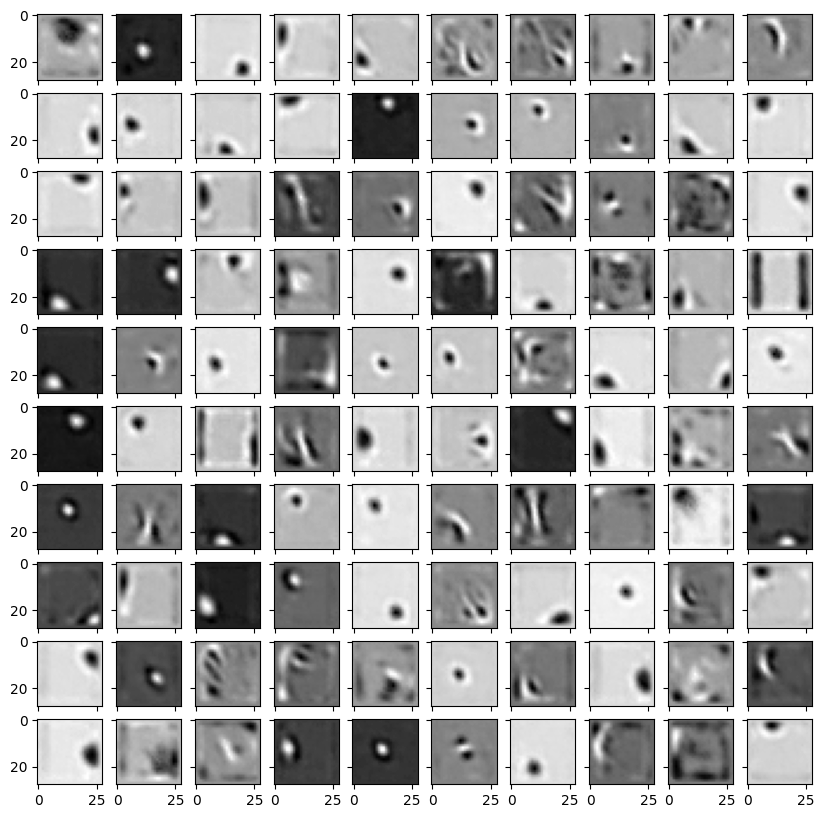

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

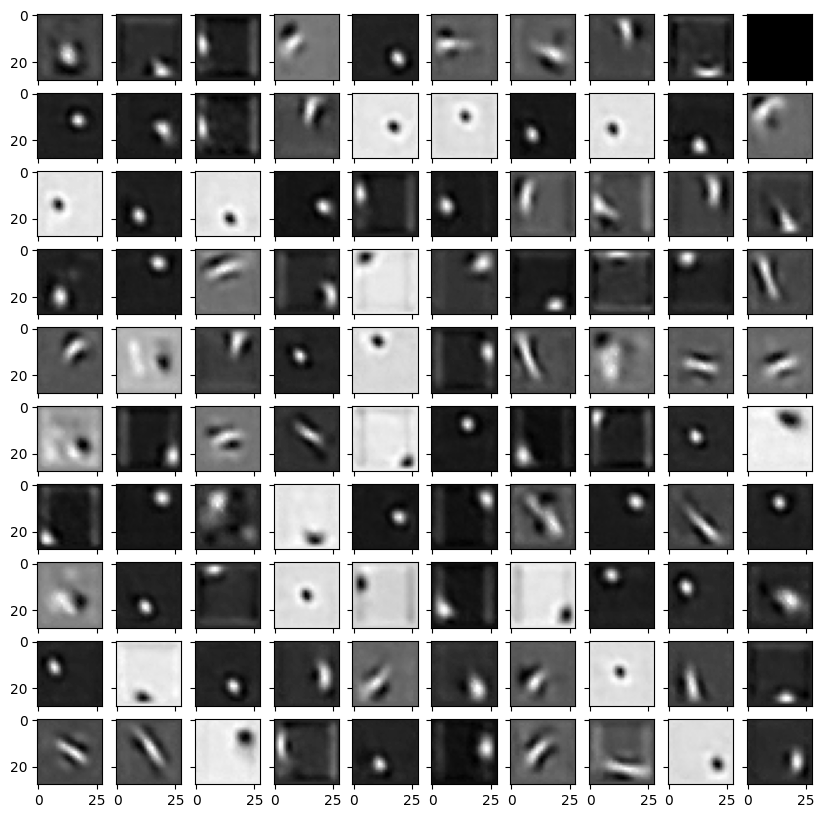

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)
learned_weights_layer_4 = get_weights(dbn_emnist, layer=3)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)
learned_weights_layer_4 = apply_threshold(learned_weights_layer_4, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_34_product = (learned_weights_23_product @ learned_weights_layer_4)  # here we do the projection

learned_weights_34_product = apply_threshold(learned_weights_34_product, 0.1)
learned_weights_34_product = apply_min_max_scaler(learned_weights_34_product)

plot_layer_receptive_fields(learned_weights_34_product.T)

The first layer filters are the most basic ones: they learn to detect circular shapes. On the last levels try to learn more difficult shapes likeoriginate more complex shapes.

## Clustering internal representations

Next step that we want to do is to examine the properties of the learned representations. Therefore, we will compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.

This implementation of the `DBN` contains internally several `RBM` objects. Therefore, we will need to compute the hidden representation using the weights of each `RBM` contained in the `DBN`.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

Of course, the representations computed using the second layer are computed using the ones from the first layer:

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)
hidden_repr_layer_4 = get_kth_layer_repr(hidden_repr_layer_3, 3, device)

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [ ]:
def get_mask(label):  # we use this function to filter by class
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(1,27)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(1,27)])

In [ ]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In [ ]:
print(mean_hidd_repr_matrix_3)


[[0.44104573 0.39507994 0.5755718  ... 0.01571084 0.58082736 0.07330067]
 [0.18227953 0.41068277 0.3741976  ... 0.32768512 0.65786177 0.14092994]
 [0.37524354 0.35376495 0.4773524  ... 0.1754701  0.13079013 0.09948314]
 ...
 [0.27645496 0.42416155 0.5461497  ... 0.02256474 0.8690674  0.08543749]
 [0.5507546  0.42388162 0.6501758  ... 0.04963392 0.58801585 0.19671217]
 [0.2133937  0.49207017 0.66204274 ... 0.09234122 0.7777052  0.09356575]]


In [ ]:
mean_hidd_repr_matrix_4 = get_hidden_reprs_matrix(hidden_repr_layer_4)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

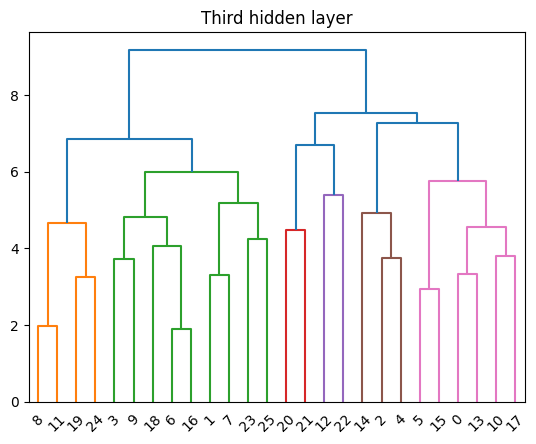

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

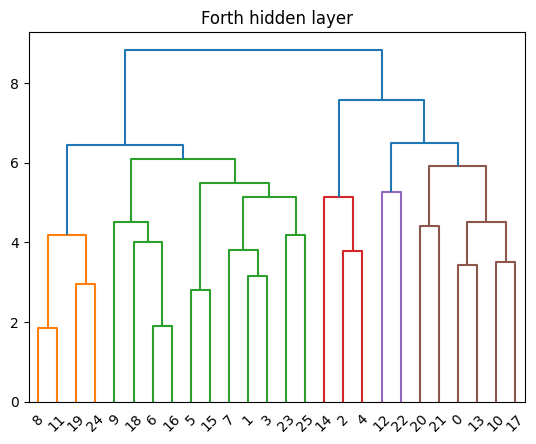

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_4, "Forth hidden layer")

Dendrogram has just hierarchically clusterasied similarity between different classes. The visualization shows that the model actually learned a hierarchical representation of the classes. The lower are the branches, the more similar are the samples of the classes with each other.  And we can see that for instance 1 label which is "A" is most similar to the  label 3 which is "C".

## Linear read-out

Now we make a linear readout of the representations computed by the DBN at each layer. We will use the representations to classify the original images with a simple linear classifier, as a way to assess how much information is contained in each hidden representatation.
Let's first define the class for the linear model:

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 27)

  def forward(self, x):
    return self.linear(x)

Then, we can instantiate a linear model for each layer of the DBN:

In [ ]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[3].W.shape[1]
linear4 = LinearModel(layer_size).to(device)

Then, we train the linear classifiers on the hidden representations from each layer using the actual labels of the EMNIST dataset as targets:

In [ ]:
def train_linear(linear, hidden_reprs, epochs=4000):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train_linear(linear1, hidden_repr_layer_1)

epoch :   1/4000, loss = 1.0094
epoch : 101/4000, loss = 0.9961
epoch : 201/4000, loss = 0.9839
epoch : 301/4000, loss = 0.9728
epoch : 401/4000, loss = 0.9625
epoch : 501/4000, loss = 0.9529
epoch : 601/4000, loss = 0.9439
epoch : 701/4000, loss = 0.9355
epoch : 801/4000, loss = 0.9277
epoch : 901/4000, loss = 0.9202
epoch : 1001/4000, loss = 0.9132
epoch : 1101/4000, loss = 0.9065
epoch : 1201/4000, loss = 0.9001
epoch : 1301/4000, loss = 0.8940
epoch : 1401/4000, loss = 0.8882
epoch : 1501/4000, loss = 0.8827
epoch : 1601/4000, loss = 0.8774
epoch : 1701/4000, loss = 0.8723
epoch : 1801/4000, loss = 0.8673
epoch : 1901/4000, loss = 0.8626
epoch : 2001/4000, loss = 0.8580
epoch : 2101/4000, loss = 0.8536
epoch : 2201/4000, loss = 0.8493
epoch : 2301/4000, loss = 0.8452
epoch : 2401/4000, loss = 0.8412
epoch : 2501/4000, loss = 0.8373
epoch : 2601/4000, loss = 0.8336
epoch : 2701/4000, loss = 0.8299
epoch : 2801/4000, loss = 0.8263
epoch : 2901/4000, loss = 0.8229
epoch : 3001/4000, l

In [ ]:
train_linear(linear2, hidden_repr_layer_2)

epoch :   1/4000, loss = 3.3205
epoch : 101/4000, loss = 1.9204
epoch : 201/4000, loss = 1.5574
epoch : 301/4000, loss = 1.4010
epoch : 401/4000, loss = 1.3108
epoch : 501/4000, loss = 1.2499
epoch : 601/4000, loss = 1.2048
epoch : 701/4000, loss = 1.1695
epoch : 801/4000, loss = 1.1407
epoch : 901/4000, loss = 1.1165
epoch : 1001/4000, loss = 1.0957
epoch : 1101/4000, loss = 1.0776
epoch : 1201/4000, loss = 1.0615
epoch : 1301/4000, loss = 1.0471
epoch : 1401/4000, loss = 1.0341
epoch : 1501/4000, loss = 1.0222
epoch : 1601/4000, loss = 1.0114
epoch : 1701/4000, loss = 1.0013
epoch : 1801/4000, loss = 0.9919
epoch : 1901/4000, loss = 0.9832
epoch : 2001/4000, loss = 0.9750
epoch : 2101/4000, loss = 0.9673
epoch : 2201/4000, loss = 0.9601
epoch : 2301/4000, loss = 0.9532
epoch : 2401/4000, loss = 0.9466
epoch : 2501/4000, loss = 0.9404
epoch : 2601/4000, loss = 0.9344
epoch : 2701/4000, loss = 0.9287
epoch : 2801/4000, loss = 0.9233
epoch : 2901/4000, loss = 0.9181
epoch : 3001/4000, l

In [ ]:
train_linear(linear3, hidden_repr_layer_3)

epoch :   1/4000, loss = 3.3429
epoch : 101/4000, loss = 1.8000
epoch : 201/4000, loss = 1.4408
epoch : 301/4000, loss = 1.2897
epoch : 401/4000, loss = 1.2021
epoch : 501/4000, loss = 1.1426
epoch : 601/4000, loss = 1.0982
epoch : 701/4000, loss = 1.0632
epoch : 801/4000, loss = 1.0344
epoch : 901/4000, loss = 1.0101
epoch : 1001/4000, loss = 0.9892
epoch : 1101/4000, loss = 0.9708
epoch : 1201/4000, loss = 0.9545
epoch : 1301/4000, loss = 0.9397
epoch : 1401/4000, loss = 0.9264
epoch : 1501/4000, loss = 0.9141
epoch : 1601/4000, loss = 0.9029
epoch : 1701/4000, loss = 0.8924
epoch : 1801/4000, loss = 0.8827
epoch : 1901/4000, loss = 0.8736
epoch : 2001/4000, loss = 0.8650
epoch : 2101/4000, loss = 0.8569
epoch : 2201/4000, loss = 0.8493
epoch : 2301/4000, loss = 0.8421
epoch : 2401/4000, loss = 0.8352
epoch : 2501/4000, loss = 0.8286
epoch : 2601/4000, loss = 0.8223
epoch : 2701/4000, loss = 0.8163
epoch : 2801/4000, loss = 0.8106
epoch : 2901/4000, loss = 0.8050
epoch : 3001/4000, l

In [ ]:
train_linear(linear4, hidden_repr_layer_4)

epoch :   1/4000, loss = 3.3376
epoch : 101/4000, loss = 1.8480
epoch : 201/4000, loss = 1.4831
epoch : 301/4000, loss = 1.3282
epoch : 401/4000, loss = 1.2382
epoch : 501/4000, loss = 1.1769
epoch : 601/4000, loss = 1.1312
epoch : 701/4000, loss = 1.0950
epoch : 801/4000, loss = 1.0654
epoch : 901/4000, loss = 1.0403
epoch : 1001/4000, loss = 1.0186
epoch : 1101/4000, loss = 0.9996
epoch : 1201/4000, loss = 0.9827
epoch : 1301/4000, loss = 0.9674
epoch : 1401/4000, loss = 0.9536
epoch : 1501/4000, loss = 0.9409
epoch : 1601/4000, loss = 0.9293
epoch : 1701/4000, loss = 0.9185
epoch : 1801/4000, loss = 0.9084
epoch : 1901/4000, loss = 0.8989
epoch : 2001/4000, loss = 0.8901
epoch : 2101/4000, loss = 0.8817
epoch : 2201/4000, loss = 0.8738
epoch : 2301/4000, loss = 0.8663
epoch : 2401/4000, loss = 0.8591
epoch : 2501/4000, loss = 0.8523
epoch : 2601/4000, loss = 0.8458
epoch : 2701/4000, loss = 0.8395
epoch : 2801/4000, loss = 0.8335
epoch : 2901/4000, loss = 0.8278
epoch : 3001/4000, l

Let's now build the representation for the test set we kept apart at the beginning, and use them to evaluate the trained linear readouts:

In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)
hidden_repr_layer_4_test = get_kth_layer_repr(hidden_repr_layer_3_test, 3, device)

In [ ]:
# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)
predictions_test4 = linear4(hidden_repr_layer_4_test)

Finally, let's compute the accuracy scores:

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
compute_accuracy(predictions_test1, emnist_test.targets)

0.7744230628013611

In [ ]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.7518269419670105

In [ ]:
compute_accuracy(predictions_test3, emnist_test.targets)

0.7852884531021118

In [ ]:
compute_accuracy(predictions_test4, emnist_test.targets)

0.7796154022216797

# COMPARISON WITH A FEED-FORWARD MODEL

In oredr to get similar in a complexity way model, we get the same number of parameters and we incresed the number of training time and decresed lr.

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size, forth_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.forth_hidden = torch.nn.Linear(third_hidden_layer_size, forth_hidden_layer_size)
    self.output = torch.nn.Linear(forth_hidden_layer_size, 27)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    forth_hidden_repr = relu(self.forth_hidden(third_hidden_repr))
    output = self.output(forth_hidden_repr)
    return output

In [ ]:
def train(network, input, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.04)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
ffnn = Feedforward(500, 600, 700, 800).to(device)

We choose the number of epochs to match the training time of the DBN and the readout layer combined.

In [ ]:
train(ffnn, emnist_train.data.reshape((124800, 784)), epochs=4000)

epoch :   1/4000, loss = 3.2965
epoch : 101/4000, loss = 3.2845
epoch : 201/4000, loss = 3.2731
epoch : 301/4000, loss = 3.2564
epoch : 401/4000, loss = 3.2152
epoch : 501/4000, loss = 3.0581
epoch : 601/4000, loss = 2.5977
epoch : 701/4000, loss = 2.1320
epoch : 801/4000, loss = 1.9540
epoch : 901/4000, loss = 1.6392
epoch : 1001/4000, loss = 1.4887
epoch : 1101/4000, loss = 1.3613
epoch : 1201/4000, loss = 1.2590
epoch : 1301/4000, loss = 1.1689
epoch : 1401/4000, loss = 1.0867
epoch : 1501/4000, loss = 1.0263
epoch : 1601/4000, loss = 0.9792
epoch : 1701/4000, loss = 0.8911
epoch : 1801/4000, loss = 0.8386
epoch : 1901/4000, loss = 0.7958
epoch : 2001/4000, loss = 0.9466
epoch : 2101/4000, loss = 0.8434
epoch : 2201/4000, loss = 0.6665
epoch : 2301/4000, loss = 0.6428
epoch : 2401/4000, loss = 0.6100
epoch : 2501/4000, loss = 0.6216
epoch : 2601/4000, loss = 0.6093
epoch : 2701/4000, loss = 0.5406
epoch : 2801/4000, loss = 0.5304
epoch : 2901/4000, loss = 0.5061
epoch : 3001/4000, l

In [ ]:
predictions_ffnn = ffnn(emnist_test.data.reshape((20800, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, emnist_test.targets)

0.8742307424545288

In the result FFNN showed better accuracy results. Probably, the number of epochs in combination with learning rate made model more accurate, than DBN. Which means if we trained DBN model a little bit longer we would get more similar results.

# ROBUSTNESS TO NOISE

We will now inject some noise in the input images and see how much the representations learned by the DBN and the feed-forward network are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

In [ ]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

Example a noisy image:

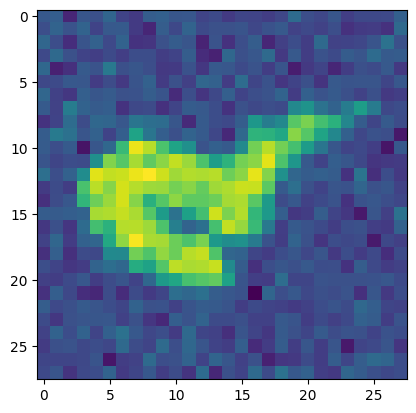

In [ ]:
noise_level = 0.1
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="viridis")

We will now compute the hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy stimuli.

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images

  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  hidden_repr_layer_4_noisy = get_kth_layer_repr(hidden_repr_layer_3_noisy, 3, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  predictions_forth_hidden_noisy = linear4(hidden_repr_layer_4_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)
  accuracy_forth_hidden = compute_accuracy(predictions_forth_hidden_noisy, emnist_test.targets)

  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_forth_hidden, accuracy_ffnn

In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of H4 read-out: %.3f" % acc[3])
print("Accuracy of FF network : %.3f" % acc[4])

Accuracy of H1 read-out: 0.698
Accuracy of H2 read-out: 0.733
Accuracy of H3 read-out: 0.766
Accuracy of H4 read-out: 0.766
Accuracy of FF network : 0.806


Let's create the psychometric curves for the DBN (at different levels of internal representations) and for the feed-forward network:

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_forth_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_forth_hidden.append(acc[3])
    accuracy_values_ffnn.append(acc[4])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_forth_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "Forth hidden", "FFNN"])

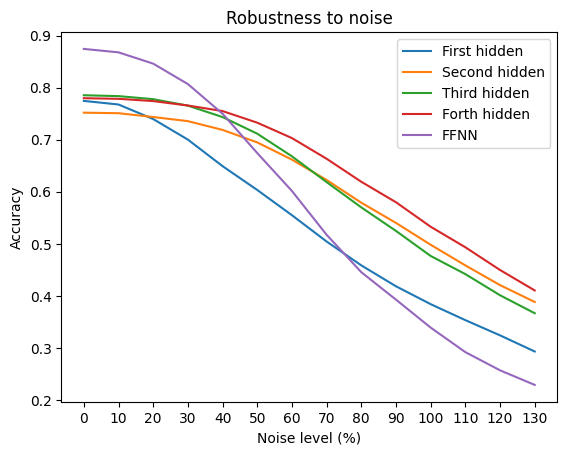

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

The DBN model demonstrates superior resistance to noise compared to the FFNN. The plot clearly illustrates that the DBN's performance deteriorates at a significantly slower rate compared to the FFNN. While initially starting slightly lower, the DBN maintains a 70% accuracy in classifying images even when subjected to a 40% level of noise corruption. In contrast, the FFNN's accuracy drops to 50% at this level of noise.

It is worth noting that even a two hidden layer in the DBN can outperform a four hidden layers configuration in terms of accuracy. However, the impact of noise on accuracy is more pronounced in the single hidden layer version compared to the two hidden layers version (although it still outperforms the FFNN's accuracy on the noisy dataset). This can be attributed to the first hidden layer acting as a "denoising" layer, which generates a cleaner hidden representation of the input. Consequently, the second hidden layer can extract a better hidden representation from this denoised input.

## Perturbing the models with adversarial attacks

### Fast gradient sign method

In general, with adversarial attacks we try to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the input, the model's parameters and the outputs: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure:
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

### Adversarial samples

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3, linear4], readout_level=2)

Let's see what an adversiarial sample looks like. Let't take one sample from the test set:

1


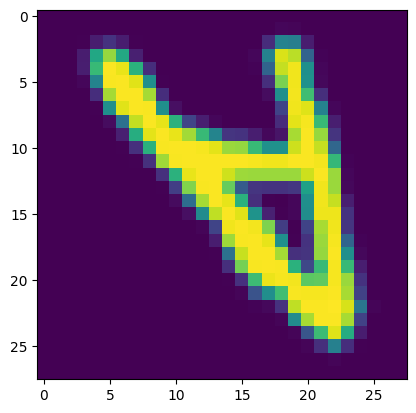

In [ ]:
test_sample_idx = 1
test_sample_label = emnist_train.classes[test_sample_idx]
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))
print(test_sample_idx)

Let's classify this "clean" image using one of the models we previously trained and then modify the image to attack the network.

To change the model we attack, you can modify the value of the `model` variable in the cell below (choosing between `ffnn` and `dbn_with_readout`).

In [ ]:
attacked_model = ffnn

In [ ]:
attacked_model = dbn_with_readout

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 1.


Let's create and visualize the corresponding adversarial sample.
The function `loss.backward()` computes the gradient for every parameter that was activated using the call `requires_grad=True`.

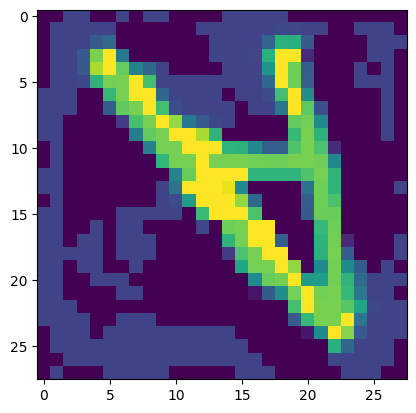

In [ ]:
epsilon = 0.2  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 24.


### Resisting to adversarial attacks

Let's now compare the ability to resist to adversarial attacks of our two models: the feedforward network and the DBN.

We will also test the ability of the DBN to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation.

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform),
    batch_size=100, shuffle=True)

Let's see how good the FFNN does:

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 0.26%



Let's now compare compare with the read-out trained on the hidden representations of the DBN:

In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 2.31%



And finally let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/208 [00:00<?, ?it/s]


Here's the original sample:



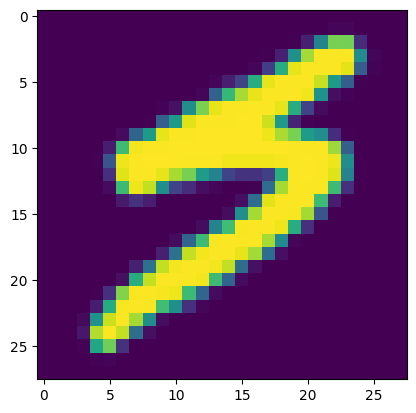


Here's a perturbed sample:



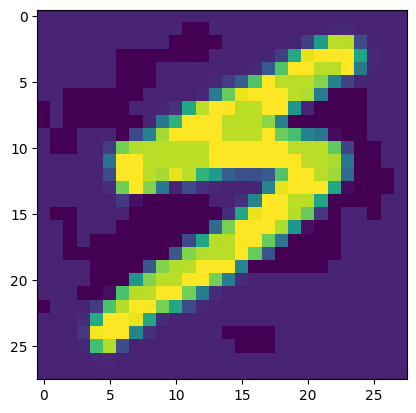


Here's what a 1-steps reconstructed sample looks like:



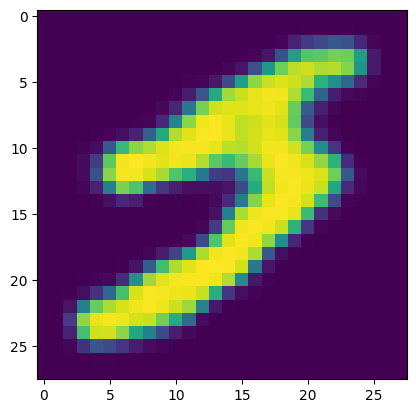


Epsilon: 0.1
Test Accuracy: 3.46%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

### Effect of the noise parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

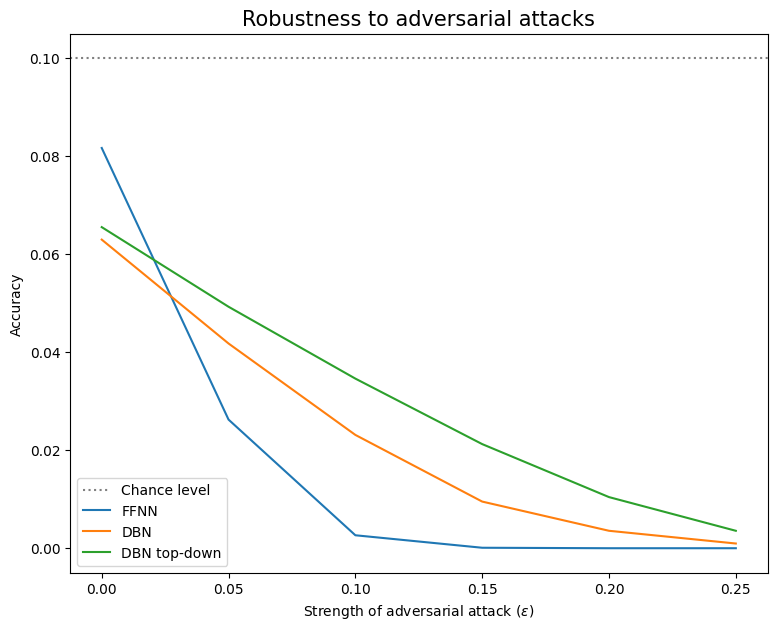

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

from the last plot we will are able to see that DBN are less vulnerable to adversarial attacks compare to FFNN. When e=0.05 FFNN drops significantly down to 20 percent accuracy, when DBNN stays on 50 percent. Even more DBNN in this
case has more linear behaviour towards the adversarial parameter.